In [ ]:
from pathlib import Path
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## Folder path
folder_path = Path.cwd().joinpath('data')

In [ ]:
## Read train data
train_df = pd.read_csv(folder_path.joinpath('train_v2.csv'))
train_df.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [ ]:
## Read transactions data
transaction_df = pd.read_csv(folder_path.joinpath('transactions_v2.csv'))
## Convert transaction and membership expiration date to datetime
transaction_df.transaction_date = pd.to_datetime(transaction_df.transaction_date, format='%Y%m%d')
transaction_df.membership_expire_date = pd.to_datetime(transaction_df.membership_expire_date, format='%Y%m%d')
transaction_df.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,2017-01-31,2017-05-04,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-08-09,2019-04-12,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,2017-03-03,2017-04-22,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,2017-03-29,2017-03-31,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,2017-04-23,0


In [ ]:
## Read members data
members_df = pd.read_csv(folder_path.joinpath('members_v3.csv'))
members_df.registration_init_time = pd.to_datetime(members_df.registration_init_time, format='%Y%m%d')
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15


In [ ]:
## Read user logs data
user_log_df = pd.read_csv(folder_path.joinpath('user_logs_v2.csv'))
user_log_df.date = pd.to_datetime(user_log_df.date, format='%Y%m%d')
user_log_df.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,2017-03-31,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,2017-03-30,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,2017-03-31,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,2017-03-31,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,2017-03-31,2,1,0,1,112,93,28401.558


## Train data EDA

In [ ]:
## Check if record for each user id is unique
len(train_df.msno.unique()) == train_df.shape[0]

True

In [ ]:
## Ground truth split
round(train_df.is_churn.value_counts() / len(train_df) * 100, 2)

0    91.01
1     8.99
Name: is_churn, dtype: float64

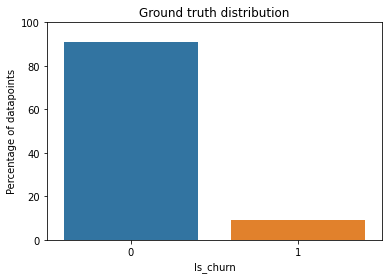

In [ ]:
sns.barplot(data=pd.DataFrame(train_df.is_churn.value_counts() /len(train_df) * 100).reset_index(), x='index', y='is_churn')
plt.ylim(0,100)
plt.title('Ground truth distribution')
plt.xlabel('Is_churn')
plt.ylabel('Percentage of datapoints')
plt.show()

It looks like each user id has only one record

## Transaction level EDA

In [ ]:
## Percentage of records with unique user id
round(len(transaction_df.msno.unique()) / len(transaction_df) * 100, 2)

83.65

## User logs EDA

In [ ]:
## Percentage of records with unique user id
round(len(user_log_df.msno.unique()) / len(user_log_df) * 100, 2)

6.0

## Modelling data preparation

Here are the steps used to prepare the modelling dataset:

1. train_df <br>
  *   Use all records since each user id has only one record and each record has a ground truth with respect to churn

2. transaction_df <br>
  *   For each user, use the latest transaction data

3. members_df <br>
  *   For all users available, use the corresponding records

4. user_log_df <br>
  *   For each user, use the aggregate sum of log features of last 1 month (Mar 1, 2017 to Mar 31, 2017)


In [ ]:
## Step 1 : Copy train_df
model_data = train_df.copy(deep=True)

In [ ]:
## Step 2 : Join latest transaction data  

## Sort records by decreasing order of transaction date
transaction_df = transaction_df.sort_values(by='transaction_date', ascending=False)

## For each user id, keep only the latest record
transaction_df.drop_duplicates('msno', inplace=True)

## Join with model data
model_data = pd.merge(model_data, transaction_df, on='msno', how='left')

In [ ]:
## Step 3 : Join user members data
model_data = pd.merge(model_data, members_df, on='msno', how='left')

In [ ]:
## Step 4 :  Join user log data
user_log_agg_df = user_log_df.groupby('msno').sum()

## Join with model_data
model_data = pd.merge(model_data, user_log_agg_df, on='msno', how='left')

In [ ]:
model_data.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,5.0,28.0,male,3.0,2013-12-23,186.0,23.0,13.0,10.0,318.0,348.0,80598.557
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36.0,30.0,180.0,180.0,0.0,2017-03-11,2017-04-11,0.0,13.0,20.0,male,3.0,2013-12-23,0.0,4.0,2.0,0.0,26.0,30.0,6986.509
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15.0,90.0,300.0,300.0,0.0,2017-03-14,2017-06-15,0.0,13.0,18.0,male,3.0,2013-12-27,239.0,57.0,32.0,22.0,205.0,432.0,67810.467
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41.0,30.0,149.0,149.0,1.0,2015-12-08,2017-12-08,0.0,1.0,0.0,NaN,7.0,2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,41.0,30.0,99.0,99.0,1.0,2017-03-16,2017-09-18,0.0,13.0,35.0,female,7.0,2014-01-25,9.0,7.0,4.0,4.0,962.0,548.0,239882.241


In [ ]:
## Save model_data to csv
model_data.to_csv(folder_path.joinpath('model_data.csv'), index=False)